This notebook helps you run a time continuous unitary rotation. 

In [27]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

from src import ( 
    measurements as measure,
    ket as ket,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo
import numpy as np
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx


In [2]:
# Define the Pauli matrices
pauli_matrices = {
    0: np.eye(2),  # Identity matrix
    1: np.array([[0, 1], [1, 0]]),  # Pauli-X
    2: np.array([[0, -1j], [1j, 0]]),  # Pauli-Y
    3: np.array([[1, 0], [0, -1]])  # Pauli-Z
}

# Define the adjacency matrix (Hamiltonian for network adjacency matrix)
HamiltonianforNetworkAdjacencyMatrix = np.array([[0.    , 0.3864, 0.    , 0.    , 0.    , 0.    , 0.    , 0.6136],
       [0.3864, 0.    , 0.6136, 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.6136, 0.    , 0.3864, 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.3864, 0.    , 0.6136, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.6136, 0.    , 0.3864, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.3864, 0.    , 0.6136, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.6136, 0.    , 0.3864],
       [0.6136, 0.    , 0.    , 0.    , 0.    , 0.    , 0.3864, 0.    ]])

# Function to create Kronecker product of Pauli matrices for 10 qubits
def string_operator(indices):
    operators = [pauli_matrices[idx] for idx in indices]
    return reduce(np.kron, operators)

# Calculate the system Hamiltonian
SysHam = np.zeros((2**8, 2**8), dtype=complex)  # Initialize a 2^10 x 2^10 matrix

# Iterate over the adjacency matrix
num_qubits = 8
for i in range(num_qubits):
    for j in range(i + 1, num_qubits):
        if HamiltonianforNetworkAdjacencyMatrix[i, j] != 0:
            # Create the term for TenStringOperator with Pauli X and Y
            term_ij = (string_operator([1 if k == i else 2 if k == j else 0 for k in range(num_qubits)]) -
                       string_operator([2 if k == i else 1 if k == j else 0 for k in range(num_qubits)]))
            # Add to the system Hamiltonian
            SysHam += HamiltonianforNetworkAdjacencyMatrix[i, j] * term_ij

print("System Hamiltonian shape:", SysHam.shape)

System Hamiltonian shape: (256, 256)


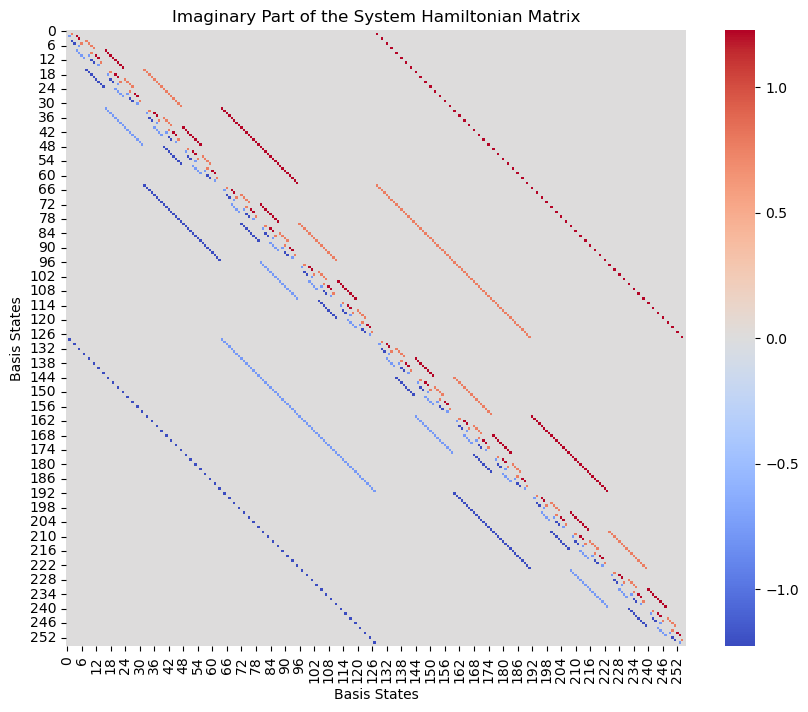

In [3]:
# Assuming SysHam is the Hamiltonian matrix from your previous calculation
# Create a matrix plot (heatmap) of the imaginary part of the system Hamiltonian
plt.figure(figsize=(10, 8))
sns.heatmap(np.imag(SysHam), cmap='coolwarm', cbar=True)

# Add labels and title
plt.title('Imaginary Part of the System Hamiltonian Matrix')
plt.xlabel('Basis States')
plt.ylabel('Basis States')

# Show the plot
plt.show()

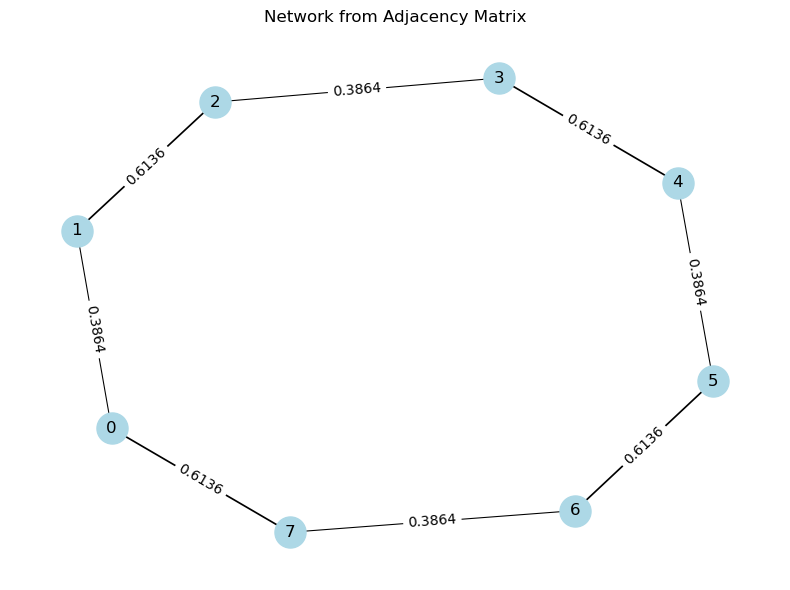

In [26]:
G = nx.from_numpy_array(HamiltonianforNetworkAdjacencyMatrix)

# Get edge weights for positioning
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

# Create spring layout
pos = nx.spring_layout(G, k=0.2, iterations=50)

# Plot the network
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, width=[w*2 for w in weights])

# Add edge labels showing weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.title("Network from Adjacency Matrix")
plt.axis('off')
plt.tight_layout()
plt.show()

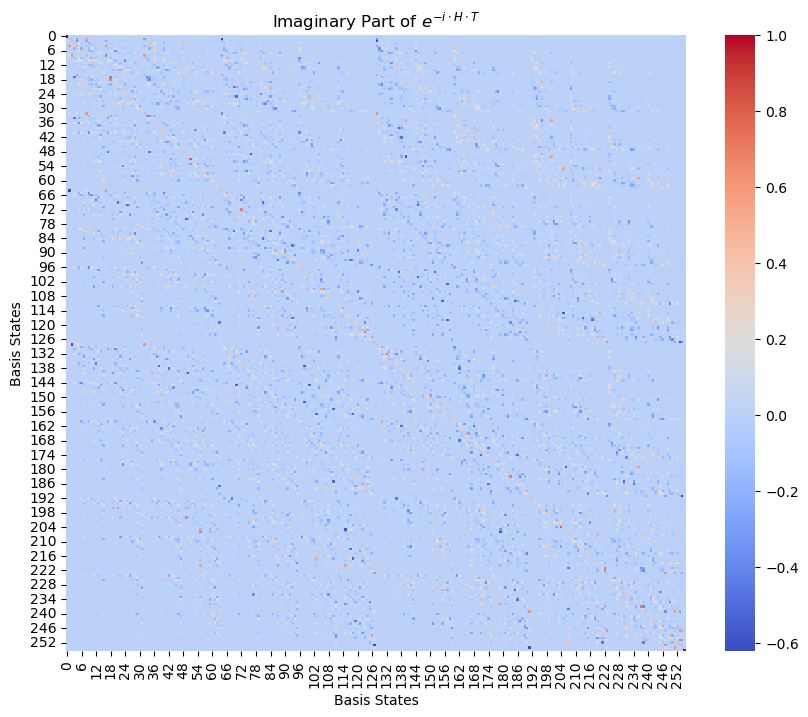

In [4]:
T = 100.0  # Example time value, can be any value

# Construct the matrix exponential of -i * SysHam * T
exp_Ham = expm(-1j * SysHam * T)

# Plot only the imaginary parts of the matrix exponential
plt.figure(figsize=(10, 8))
sns.heatmap(np.real(exp_Ham), cmap='coolwarm', cbar=True)

# Add labels and title
plt.title(r'Imaginary Part of $e^{-i \cdot H \cdot T}$')
plt.xlabel('Basis States')
plt.ylabel('Basis States')

# Show the plot
plt.show()

In [5]:
initial_pops = [0.1, 0.1, .1, .1,0.4,0.1,0.1,0.1]
system = DM.n_thermal_qbits(initial_pops)
basiiis=ket.canonical_basis(8)

sys=system.data
dense_matrix = sys.toarray()

Unitaryy=exp_Ham
ConjUnitaryy= exp_Ham.conj()

In [6]:
transformed=DM.DensityMatrix(np.matmul(np.matmul(Unitaryy,dense_matrix),ConjUnitaryy),basiiis)

In [7]:
DM.DensityMatrix.ptrace(transformed,numbers).data.toarray()[1][1]

NameError: name 'numbers' is not defined

In [8]:
def compute_populations(initial_pops, SysHam,T, basiiis):
    # Generate the initial thermal density matrix
    system = DM.n_thermal_qbits(initial_pops)
    sys = system.data
    dense_matrix = sys.toarray()

    # Initialize a list to store populations at each time step
    popstrans = []
    popstrans.append(initial_pops)

    # Loop through time steps
    for t in range(T):
        # Calculate the unitary evolution operator
        Unit = expm(-1j * SysHam * (np.pi/15)*t)
        ConjUnit = Unit.conj()
        adjoint_Unit = ConjUnit.T 

        # Update the density matrix
        transformed = DM.DensityMatrix(np.matmul(np.matmul(Unit, dense_matrix), adjoint_Unit), basiiis)

        # Initialize a list to store populations for this time step
        pop_at_t = []

        # Loop through qubit indices
        for q_index in range(8):
            # Create a list of qubits and remove the current index
            qbits = list(range(8))
            qbits.remove(q_index)

            # Calculate the reduced density matrix and append the population to pop_at_t
            pop_at_t.append(DM.DensityMatrix.ptrace(transformed, qbits).data.toarray()[1][1])

        # Append the populations at time t to popstrans
        popstrans.append(pop_at_t)

    # Return the populations for all time steps
    return popstrans

In [9]:
data=compute_populations(initial_pops, SysHam,200, basiiis)

/Users/unnatiakhouri/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/unnatiakhouri/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


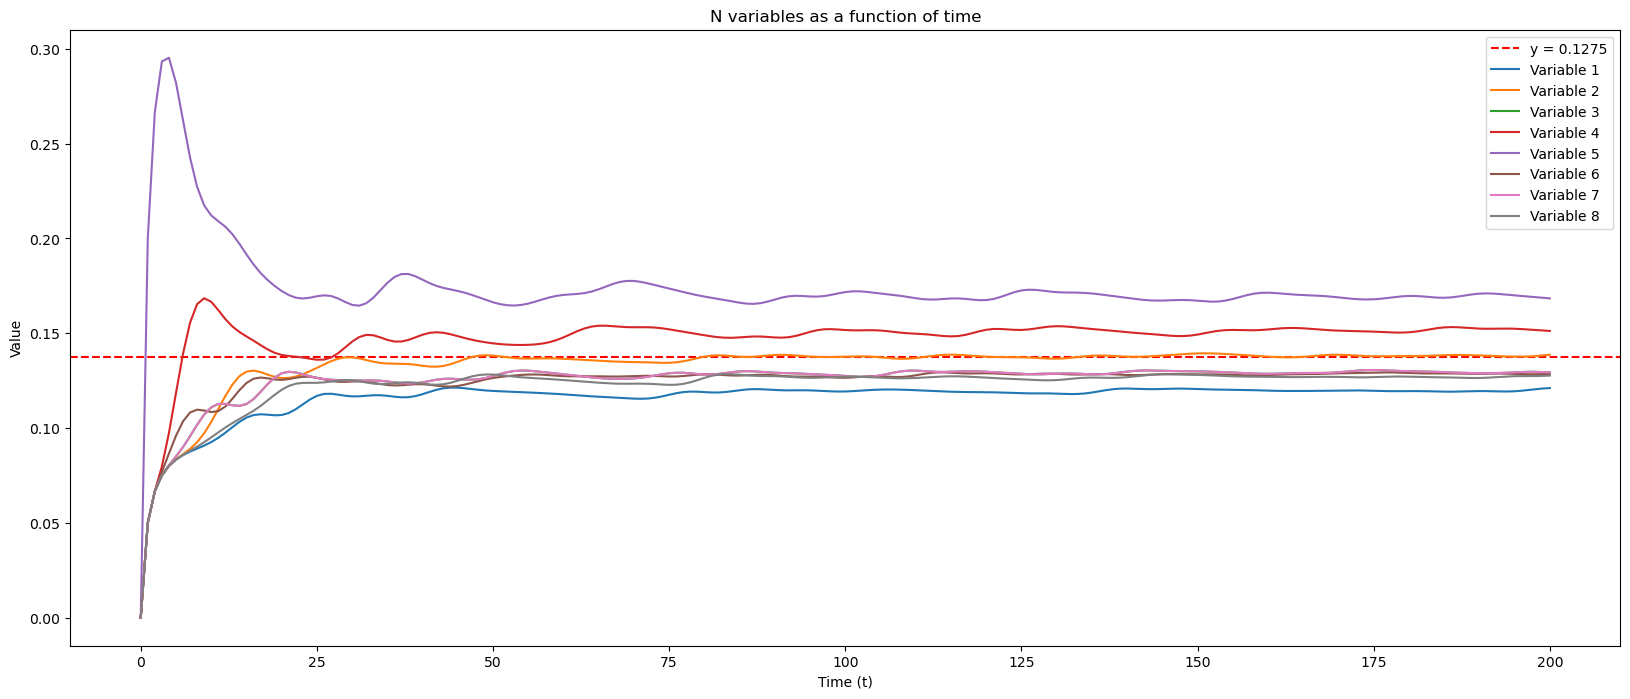

In [10]:
def time_averaged_one_point_measures_at_t(dataset,t):
    # Assuming dataset is list of 100 lists i.e. one trial
    #stack datasets in 3D
    # Take the ensemble average along the first axis (averaging over all datasets)
    sum_till_t = np.sum(dataset[:t], axis=0)
    time_average_t = (1/(t+1))*(sum_till_t)
    return (time_average_t)

def time_averaged_one_point_measures_matrix_full_sim(dataset):
    # Take the ensemble average along the first axis (averaging over all datasets)
    time_average=[]
    for t in range(len(dataset)):
        time_average.append(time_averaged_one_point_measures_at_t(dataset,t))
    return (time_average)


num_time_steps = len(data)  # The number of rows in the data corresponds to the number of time steps
t = np.arange(num_time_steps)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]
    
dataplot=np.array(time_averaged_one_point_measures_matrix_full_sim(np.array(data[0:])))
data_transposed = dataplot.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]
plt.figure(figsize=(20, 8))
plt.axhline(y=0.1375, color='r', linestyle='--', label=f'y = {0.1275}')

    
# Plot each number as a function of t
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}')
    
# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time')
plt.legend()
    
# Show the plot
plt.show()

/Users/unnatiakhouri/miniconda3/lib/python3.12/site-packages/numpy/ma/core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


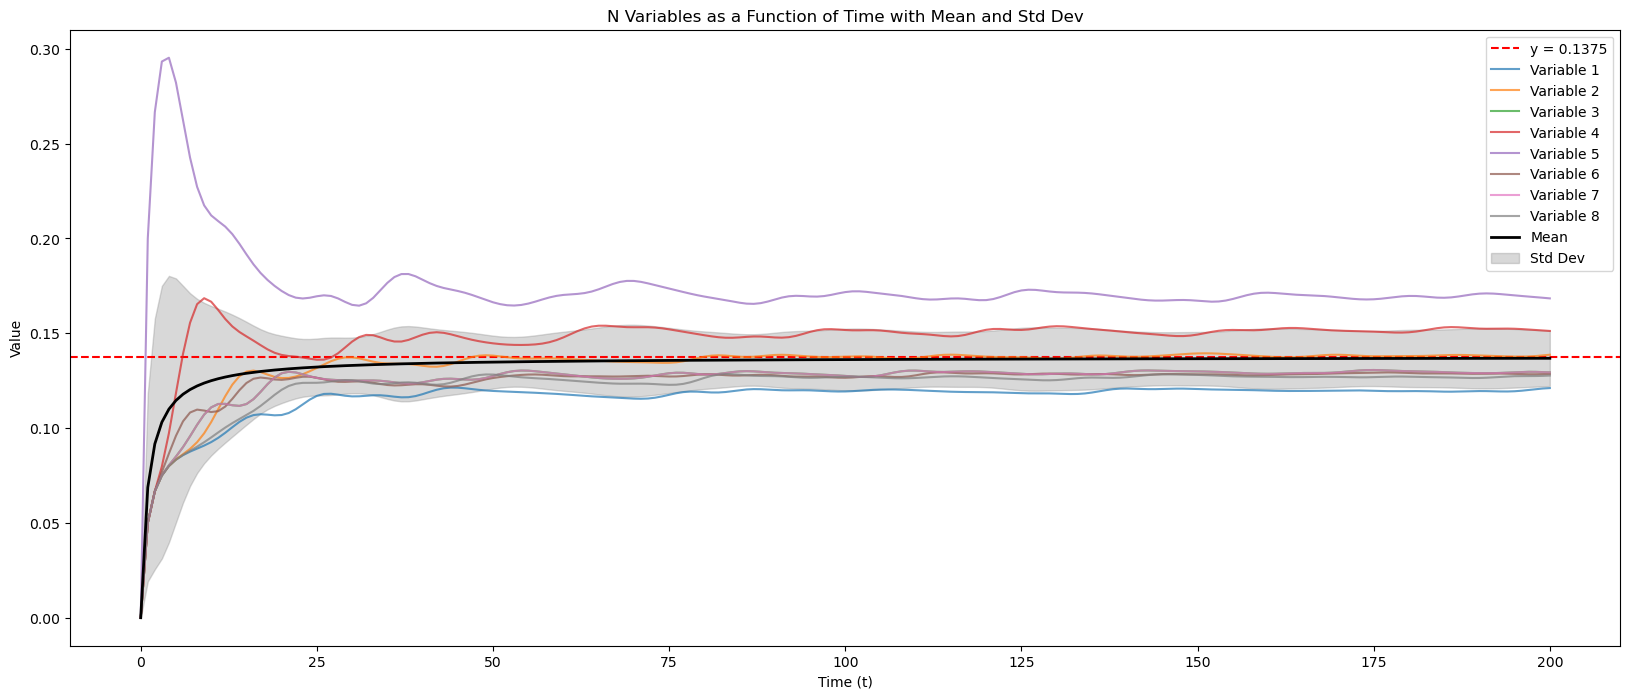

In [11]:
num_time_steps = len(data)  # Number of time steps
t = np.arange(num_time_steps)  # Time steps [0, 1, 2, ..., num_time_steps-1]

# Process the data
dataplot = np.array(time_averaged_one_point_measures_matrix_full_sim(np.array(data[0:])))
data_transposed = dataplot.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]

# Calculate the mean and standard deviation across variables (rows) over time (columns)
mean_values = np.mean(data_transposed, axis=0)
std_values = np.std(data_transposed, axis=0)

# Plot settings
plt.figure(figsize=(20, 8))
plt.axhline(y=0.1375, color='r', linestyle='--', label=f'y = {0.1375}')  # Horizontal line for reference

# Plot each variable as a function of time
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}', alpha=0.7)

# Plot the mean and standard deviation
plt.plot(t, mean_values, label='Mean', color='black', linewidth=2, linestyle='-', zorder=10)
plt.fill_between(t, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.3, label='Std Dev')

# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N Variables as a Function of Time with Mean and Std Dev')
plt.legend()

# Show the plot
plt.show()

In [14]:
def is_hermitian(matrix):
    # Check if the matrix is equal to its conjugate transpose
    return np.array_equal(matrix, np.conjugate(matrix.T))
                          
def is_unitary(matrix):
    # Calculate the conjugate transpose of the matrix
    conjugate_transpose = np.conjugate(matrix.T)
    
    # Calculate the product of the matrix and its conjugate transpose
    product = np.dot(matrix, conjugate_transpose)
    
    # Create the identity matrix of the same size as the input matrix
    identity_matrix = np.eye(matrix.shape[0])
    
    # Check if the product is approximately equal to the identity matrix
    return np.allclose(product, identity_matrix)


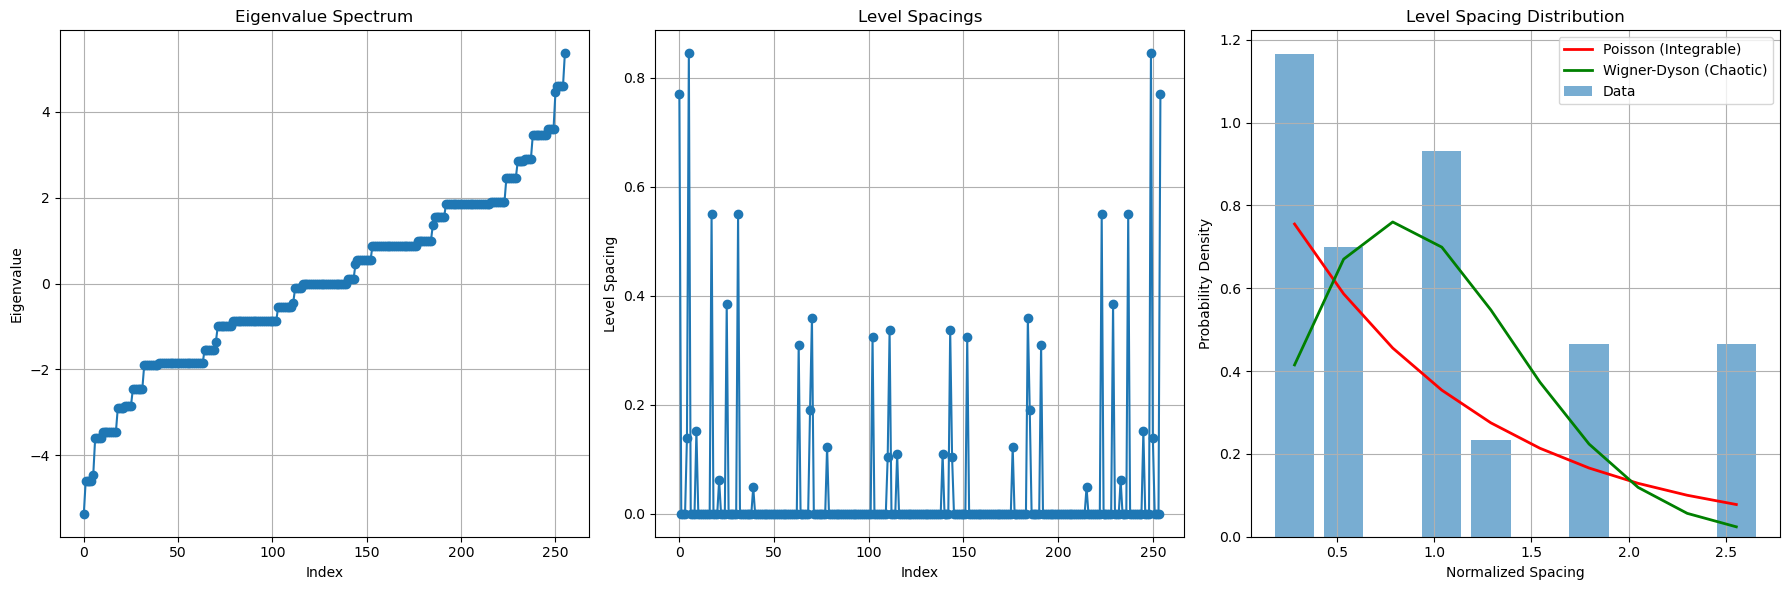

{'eigenvalues': array([-5.35491008e+00, -4.58478877e+00, -4.58478877e+00, -4.58478877e+00,
        -4.58478877e+00, -4.44611008e+00, -3.60180727e+00, -3.60180727e+00,
        -3.60180727e+00, -3.60180727e+00, -3.45025504e+00, -3.45025504e+00,
        -3.45025504e+00, -3.45025504e+00, -3.45025504e+00, -3.45025504e+00,
        -3.45025504e+00, -3.45025504e+00, -2.90051008e+00, -2.90051008e+00,
        -2.90051008e+00, -2.90051008e+00, -2.83890493e+00, -2.83890493e+00,
        -2.83890493e+00, -2.83890493e+00, -2.45440000e+00, -2.45440000e+00,
        -2.45440000e+00, -2.45440000e+00, -2.45440000e+00, -2.45440000e+00,
        -1.90465504e+00, -1.90465504e+00, -1.90465504e+00, -1.90465504e+00,
        -1.90465504e+00, -1.90465504e+00, -1.90465504e+00, -1.90465504e+00,
        -1.85592343e+00, -1.85592343e+00, -1.85592343e+00, -1.85592343e+00,
        -1.85592343e+00, -1.85592343e+00, -1.85592343e+00, -1.85592343e+00,
        -1.85592343e+00, -1.85592343e+00, -1.85592343e+00, -1.85592343e+0

In [15]:
def analyze_hamiltonian(H, plot=True, bins=10):
    """
    Analyze the eigenvalue spectrum of a Hamiltonian matrix.
    
    Parameters:
    -----------
    H : numpy.ndarray
        The Hamiltonian matrix to analyze.
    plot : bool, optional
        Whether to generate plots of the spectrum and spacing distributions (default: True).
    bins : int, optional
        Number of bins for the spacing histogram (default: 10).
        
    Returns:
    --------
    dict
        A dictionary containing eigenvalues, spacings, and statistical measures.
    """
    # Check if the matrix is Hermitian
    is_hermitian = np.allclose(H, H.conj().T)
    if not is_hermitian:
        print("Warning: The matrix is not Hermitian. Results may not have physical interpretation.")
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues = np.sort(np.linalg.eigvalsh(H))
    
    # Calculate level spacings
    level_spacings = np.diff(eigenvalues)
    
    # Remove near-zero spacings (degeneracies)
    epsilon = 1e-10
    non_zero_spacings = level_spacings[level_spacings > epsilon]
    
    # Calculate statistics
    avg_spacing = np.mean(non_zero_spacings) if len(non_zero_spacings) > 0 else 0
    std_spacing = np.std(non_zero_spacings) if len(non_zero_spacings) > 0 else 0
    
    # Unfold the spectrum (normalize the spacings)
    unfolded_spacings = non_zero_spacings / avg_spacing if avg_spacing > 0 else []
    
    # Calculate level repulsion metrics
    min_spacing = np.min(non_zero_spacings) if len(non_zero_spacings) > 0 else 0
    max_spacing = np.max(non_zero_spacings) if len(non_zero_spacings) > 0 else 0
    spacing_ratio = max_spacing / min_spacing if min_spacing > 0 else float('inf')
    
    # Prepare histogram data for spacing distribution
    if len(unfolded_spacings) > 0:
        hist, bin_edges = np.histogram(unfolded_spacings, bins=bins, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    else:
        hist, bin_centers = [], []
        
    # Theoretical distributions
    if len(bin_centers) > 0:
        # Poisson distribution (integrable systems)
        poisson = np.exp(-bin_centers)
        
        # Wigner-Dyson distribution (GOE - Gaussian Orthogonal Ensemble)
        wigner = (np.pi/2) * bin_centers * np.exp(-(np.pi/4) * bin_centers**2)
    else:
        poisson, wigner = [], []
    
    # Create plots if requested
    if plot and len(eigenvalues) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot eigenvalue spectrum
        axes[0].plot(range(len(eigenvalues)), eigenvalues, 'o-', markersize=6)
        axes[0].set_xlabel('Index')
        axes[0].set_ylabel('Eigenvalue')
        axes[0].set_title('Eigenvalue Spectrum')
        axes[0].grid(True)
        
        # Plot level spacings
        if len(level_spacings) > 0:
            axes[1].plot(range(len(level_spacings)), level_spacings, 'o-', markersize=6)
            axes[1].set_xlabel('Index')
            axes[1].set_ylabel('Level Spacing')
            axes[1].set_title('Level Spacings')
            axes[1].grid(True)
            
        # Plot spacing distribution with theoretical comparisons
        if len(hist) > 0 and len(bin_centers) > 0:
            axes[2].bar(bin_centers, hist, width=(bin_edges[1]-bin_edges[0])*0.8, 
                        alpha=0.6, label='Data')
            
            if len(poisson) > 0 and len(wigner) > 0:
                axes[2].plot(bin_centers, poisson, 'r-', lw=2, 
                             label='Poisson (Integrable)')
                axes[2].plot(bin_centers, wigner, 'g-', lw=2, 
                             label='Wigner-Dyson (Chaotic)')
                
            axes[2].set_xlabel('Normalized Spacing')
            axes[2].set_ylabel('Probability Density')
            axes[2].set_title('Level Spacing Distribution')
            axes[2].legend()
            axes[2].grid(True)
            
        plt.tight_layout()
        plt.show()
    
    # Calculate additional statistical tests
    results = {
        'eigenvalues': eigenvalues,
        'level_spacings': level_spacings,
        'non_zero_spacings': non_zero_spacings,
        'unfolded_spacings': unfolded_spacings,
        'avg_spacing': avg_spacing,
        'std_spacing': std_spacing,
        'coefficient_of_variation': std_spacing / avg_spacing if avg_spacing > 0 else float('inf'),
        'min_spacing': min_spacing,
        'max_spacing': max_spacing,
        'spacing_ratio': spacing_ratio,
        'is_hermitian': is_hermitian,
        'degeneracy_count': len(level_spacings) - len(non_zero_spacings),
    }
    
    # Nearest-neighbor spacing statistics
    if len(unfolded_spacings) > 3:
        # Brody parameter fit (interpolates between Poisson and Wigner-Dyson)
        try:
            # Initial guesses for the Brody distribution parameters
            initial_params = [1.0]  # Initial guess for Brody parameter
            
            # Define Brody distribution
            def brody_pdf(s, beta):
                alpha = (gamma(((beta + 2)/(beta + 1))))**(beta + 1)
                return (beta + 1) * alpha * s**beta * np.exp(-alpha * s**(beta + 1))
            
            # Fit the Brody distribution using curve_fit
            from scipy.optimize import curve_fit
            from scipy.special import gamma
            
            # Filter out extreme values for better fitting
            s_values = unfolded_spacings[unfolded_spacings < 5]
            if len(s_values) > 5:  # Need enough points for a meaningful fit
                params, _ = curve_fit(brody_pdf, s_values, 
                                      np.ones_like(s_values) * (1/avg_spacing),
                                      p0=initial_params, maxfev=10000)
                brody_param = params[0]
                
                results['brody_parameter'] = brody_param
                results['chaoticity'] = brody_param / (brody_param + 1)  # 0: Poisson, 1: Wigner-Dyson
                
                # Calculate Kullback-Leibler divergence to theoretical distributions
                if len(hist) > 0 and len(poisson) > 0 and len(wigner) > 0:
                    # Ensure all values are positive and normalized
                    hist_norm = hist / np.sum(hist)
                    hist_norm = np.clip(hist_norm, 1e-10, None)
                    
                    poisson_norm = poisson / np.sum(poisson)
                    poisson_norm = np.clip(poisson_norm, 1e-10, None)
                    
                    wigner_norm = wigner / np.sum(wigner)
                    wigner_norm = np.clip(wigner_norm, 1e-10, None)
                    
                    # Calculate KL divergence
                    kl_poisson = stats.entropy(hist_norm, poisson_norm)
                    kl_wigner = stats.entropy(hist_norm, wigner_norm)
                    
                    results['kl_divergence_poisson'] = kl_poisson
                    results['kl_divergence_wigner'] = kl_wigner
                    results['closer_to'] = 'Poisson (integrable)' if kl_poisson < kl_wigner else 'Wigner-Dyson (chaotic)'
        except:
            # Fitting might fail for small matrices or special cases
            pass
    
    return results

analyze_hamiltonian(SysHam)